# Titanic Data Analysis

## The Problem
**On April 15, 1912**, the Titanic sank after colliding with an iceberg, killing **1502 out of 2224** passengers and crew. Predicting which passengers lived and which died is a classic problem in data science. The classic dataset on Titanic passengers includes **11 variables**:

1. Survival
2. Pclass
3. Name
4. Sex
5. Age
6. SibSp
7. Parch
8. Ticket
9. Fare
10. Cabin
11. Embarked

The task is to predict the `Survived` variable using the other ten variables.

We begin by downloading the data for the 'titanic' competition from the 'gettingStarted' competition list via the Kaggle API. Note that before running this code, we need to `pip install kaggle` and also obtain Kaggle API credentials from the Kaggle website, which we save in the `.kaggle` folder in the user's home directory.

In [511]:
from kaggle.api.kaggle_api_extended import KaggleApi
kaggleApi = KaggleApi()
kaggleApi.authenticate()
print(kaggleApi.competition_list_files(competition='titanic'))
kaggleApi.competition_download_files(competition='titanic')

[train.csv, gender_submission.csv, test.csv]


The downloaded data is stored in `titanic.zip`, which we unzip into the `data` directory using `shutil.unpack_archive()` (a Python base library function):

In [512]:
from shutil import unpack_archive

unpack_archive(filename='titanic.zip', extract_dir='data')

Note that the data is pre-split into train and test sets. We import these into a Pandas DataFrame using `pd.read_csv()`. (We will, of course, need to `pip install pandas` before running the following code.)

In [513]:
# Import data/test.csv and data/train.csv into Pandas DataFrames
import pandas as pd

train = pd.read_csv(filepath_or_buffer='data/train.csv')
test = pd.read_csv(filepath_or_buffer='data/test.csv')

There is additionally a `gender_submission.csv` file, which we ignore for now. This is simply a sample submission file.

## Variables

Our next task is to grok the training dataset to see what variables are available to us. Useful functions for this include:

- `df.shape()`, which gives us the number of rows and columns in the DataFrame
- `df.columns()`, which gives us the names of the columns
- `df.head()`, which gives us the first five rows of the DataFrame, or `df.tail()`, which gives us the last five rows of the DataFrame
- `df.sample(n)` or `df.sample(frac)`, which gives us a random sample of `n` rows or `frac` fraction of the rows, respectively
- `df.info()`, which gives us the number of non-null entries in each column, as well as the data type of each column
- `df.describe()`, which gives us summary statistics for each column
- `df.value_counts()`, which gives us the number of occurrences of each value in a column
- `df.unique()`, which gives us the unique values in a column

For example,

In [514]:
# Get column names and non-null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [515]:
# Count unique values for each int64 or object column
for column in train.select_dtypes(include=['int64', 'object']).columns:
    print(column, train[column].nunique())

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
SibSp 7
Parch 7
Ticket 681
Cabin 147
Embarked 3


In [516]:
# Count occurrences of each unique value in columns with only a few unique values
for column in train.select_dtypes(include=['int64', 'object']).columns:
    if train[column].nunique() < 10:
        print(train[column].value_counts())

Survived
0    549
1    342
Name: count, dtype: int64
Pclass
3    491
1    216
2    184
Name: count, dtype: int64
Sex
male      577
female    314
Name: count, dtype: int64
SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
Parch
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


In [517]:
# Use describe to statistically summarize float64 columns
train.select_dtypes(include=['float64']).describe()

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200



Based on our examination of the data (and Kaggle-provided [metadata](https://www.kaggle.com/c/titanic/data) about what the various variables represent), we can make the following observations:

1. **Age**: Most ages are round numbers, but some are fractional because they are either estimated or less than 1. There are many missing values. Ages range from >1 to 80, with a mean around 30.

2. **SibSp**: `SibSp`, short for sibling-spouse, indicates whether the passenger had a sibling or spouse aboard the Titanic. Sibling is defined as a brother, sister, stepbrother, or stepsister. Spouse is defined as a husband or wife (mistresses and fiancés are ignored). This is an ordinal integer feature with the following possible values: 0, 1, 2, 3, 4, 5, 6, 7, and 8. The feature corresponds to the total number of siblings and spouses aboard the Titanic for each passenger. Most passengers had 0.

3. **Parch**: `Parch`, short for parent-child, indicates whether the passenger had a parent or child aboard the Titanic. A parent is defined as a mother or father. A child is defined as a daughter, son, stepdaughter, or stepson. Children that traveled only with a nanny were ignored. This is an ordinal integer feature with the following possible values: 0, 1, 2, 3, 4, 5, and 6. The feature corresponds to the total number of parents and children aboard the Titanic for each passenger. Most passengers had 0.

4. **Pclass**: `Pclass` is a proxy for socio-economic status (SES). This is an ordinal integer feature with the following possible values: 1, 2, and 3. The feature corresponds to the ticket class of each passenger. A value of 1 corresponds to upper class, 2 corresponds to middle class, and 3 corresponds to lower class. Most passengers were in upper class.

4. **Embarked**: `Embarked` is a nominal categorical feature that has the following possible values: C, Q, and S. These correspond to the ports of embarkation, which are Cherbourg, Queenstown, and Southampton, respectively. Most passengers embarked at Southampton. There are a few missing values.
 
5. **Name**: `Name` is a nominal categorical feature that contains the names of each passenger.

6. **Sex**: `Sex` is a nominal categorical feature with the possible values M and F. Most passengers were male.
 
7. **Ticket**: `Ticket` is a nominal alphanumeric feature that contains the ticket number for each passenger.

8. **Cabin**: `Cabin` is a nominal alphanumeric feature that contains the cabin number for each passenger. Some passengers shared cabins, so this feature is not unique to each passenger. Most values are missing.

9.  **Fare**: `Fare` is a continuous float feature that contains the value each passenger paid for their ticket in British pounds. Fares ranged from 0 to around 512 pounds. The mean fare was around 32 pounds.

10. **PassengerId**: `PassengerId` is a nominal integer feature that contains a unique ID number for each passenger.

11. **Survived**: `Survived` is a binary categorical feature with the possible values 0 and 1. A value of 1 indicates that the passenger survived, and a value of 0 indicates that the passenger died.

Let's also glance at the test data to make sure it has the same column names and similar missing values:

In [518]:
# Get column names and non-null values
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


Here we observe that although the `train` dataset had no missing Fare values, the `test` dataset has one missing Fare value. We will need to account for this in our model training pipeline.

## Hypotheses

We would expect Age, Sex, Pclass, and Fare to have strong effects on survival, given the social norms of the early 20th century. Passengers with large families might also have received deferential treatment, so SibSp and Parch are likely relevant. These are the most salient variables.

Embarked and Name could perhaps be used in feature engineering to infer additional relevant information about the passenger's social class or ethnicity, though we would expect the information gain to be small. The most relevant information about social class is likely already captured by Pclass.

Ticket number might indicate something about when the ticket was booked, but we would not really expect this to affect survival outcomes. Cabin number could perhaps be used in feature engineering for social network analysis, but we would not expect it to have a large effect on survival. PassengerId is a unique identifier for each passenger, so it should have no effect on survival. These are probably the least salient variables.

## Data Exploration and Visualization

We've learned some basic information about the data, but we can learn more by visualizing the data. We'll use the `matplotlib` and `seaborn` libraries for this. (We'll need to `pip install matplotlib` and `pip install seaborn` before running the following code.)

In [519]:
# Import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Display matplotlib plots inside Jupyter Notebook rather than in a new window
%matplotlib inline

# Set style for seaborn plots
sns.set(style='white', context='notebook', palette='deep')

We'll begin by investigating the distributions of each of the variables. We'll use histograms for the continuous variables, and bar charts for the categorical variables.

<Figure size 640x480 with 0 Axes>

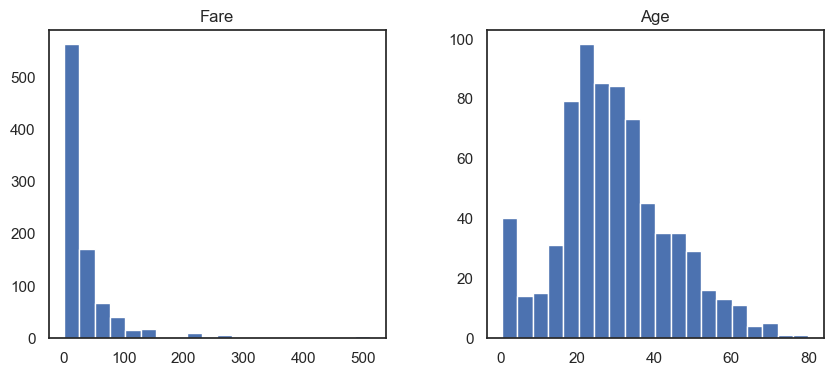

<Figure size 640x480 with 0 Axes>

In [520]:
# Display histograms for the two continuous variables, Fare and Age
train[['Fare', 'Age']].hist(figsize=(10, 4), bins=20, grid=False)
plt.figure()

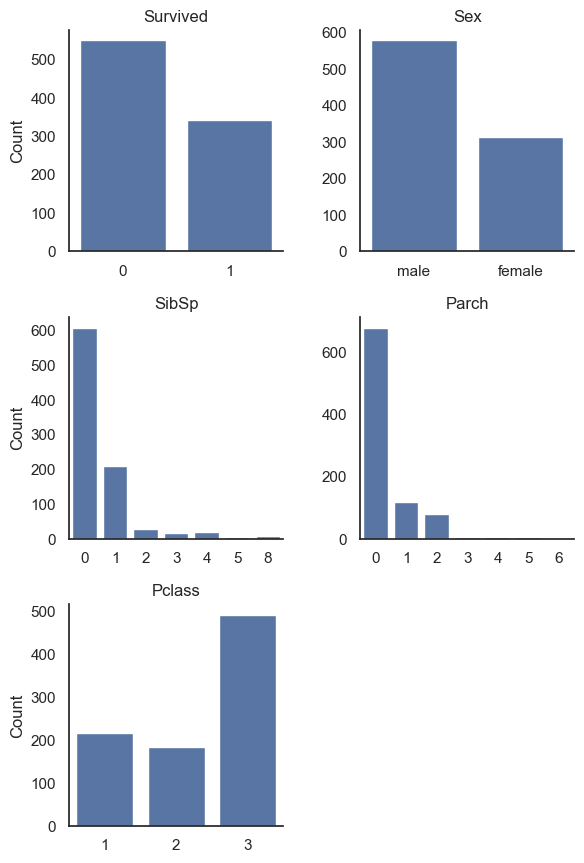

In [521]:
# Melt the data to long-form
melted_data = pd.melt(frame=train, value_vars=['Survived', 'Sex', 'SibSp', 'Parch', 'Pclass'])

# Function to handle plotting within FacetGrid
def custom_countplot(x, **kwargs):
    sns.countplot(x=x, **kwargs)

# Create the FacetGrid
g = sns.FacetGrid(data=melted_data, col='variable', col_wrap=2, sharex=False, sharey=False)
g = g.map(custom_countplot, 'value')

# Adjust the axis labels and titles
g.set_axis_labels(x_var="", y_var="Count")
g.set_titles(template="{col_name}")

# Show the plots
plt.show()

We also want to understand the relationships between variables. We can do this at a glance with a table of correlation coefficients, although this will only tell us about linear relationships:

In [522]:
# Convert the Sex column to a numeric variable in both train and test
train['Sex'] = train['Sex'].map(arg={'female': 0, 'male': 1}).astype(dtype=int)
test['Sex'] = test['Sex'].map(arg={'female': 0, 'male': 1}).astype(dtype=int)

# Create a table of correlation coefficients for each variable pair
train.drop(columns=['Name', 'Embarked', 'PassengerId', 'Cabin', 'Ticket']).corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,0.131900,-0.369226,0.083081,0.018443,-0.549500
Sex,-0.543351,0.131900,1.000000,0.093254,-0.114631,-0.245489,-0.182333
Age,-0.077221,-0.369226,0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.114631,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.245489,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,-0.182333,0.096067,0.159651,0.216225,1.000000


Here we see a strong relationship between 'SibSp' and 'Parch', which makes sense, since these are both measures of family size. The strong correlation we observe between 'Pclass' and 'Fare' also makes sense, given that upper class tickets tend to be more expensive. Women on the Titanic were more likely to have parent-child or sibling-spouse relationships, while men were more likely to have paid a higher fare.

Of greater relevance for our forecasting task, we observe a strong relationship between 'Survived' and 'Sex', and weaker relationships between 'Survived' and 'Pclass' and 'Fare'. Surprisingly, the relationship of 'Survived' to 'Age' and 'Parch' is quite weak.

Since 'Embarked' is categorical and not ordinal, we can't use a correlation coefficient to measure its relationships to other variables. Instead, we can group the data by 'Embarked' and compute the means of other variables for each group:

In [523]:
# Group by Embarked and summarize survival rate
train.drop(columns=['Name', 'PassengerId', 'Cabin', 'Ticket']).groupby(by='Embarked').mean()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,0.553571,1.886905,0.565476,30.814769,0.386905,0.363095,59.954144
Q,0.389610,2.909091,0.532468,28.089286,0.428571,0.168831,13.276030
S,0.336957,2.350932,0.684783,29.445397,0.571429,0.413043,27.079812


Surprisingly, we see a significantly higher survival rate for embarkations from Cherbourg. This is probably due to confounding variables, such as the fact that Cherbourg passengers were more likely to be female and upper class and to have paid a higher fare. The survival rate for Queenstown is also higher than for Southampton even though Queenstown passengers were on average lower class and paid the lowest fares. This might be related to our sex variable, as Queenstown passengers were the most female. Queenstown is also where the crew embarked from, so we have to consider whether crew survived at a higher rate than other passengers. We can investigate this further by grouping the data by 'Embarked' and 'Pclass' and computing the mean 'Sex', 'Fare', and 'Survived' for each group:

In [524]:
# Group by Embarked and Pclass and summarize survival rate
train[['Embarked', 'Pclass', 'Sex', 'Fare', 'Survived']].groupby(by=['Embarked', 'Pclass']).mean()

Sex        Fare  Survived
Embarked Pclass                                
C        1       0.494118  104.718529  0.694118
         2       0.588235   25.358335  0.529412
         3       0.651515   11.214083  0.378788
Q        1       0.500000   90.000000  0.500000
         2       0.333333   12.350000  0.666667
         3       0.541667   11.183393  0.375000
S        1       0.622047   70.364862  0.582677
         2       0.591463   20.327439  0.463415
         3       0.750708   14.644083  0.189802

Sure enough, we find that departures from Cherbourg and Queenstown exhibit generally higher survival rates than departures from Southampton across all three social classes, but that sex and fare may explain a lot of the difference.

(Note that while the survival rates for first- and second-class passengers for Queenstown violate the pattern a bit, that's because there are only a few passengers in these groups. We can get more insight into the size of each group by using a contingency table, as shown below.)

In [525]:
# Create a contingency table indexing Survived against Pclass and Embarked
contingency_table = pd.crosstab(index=train['Survived'], columns=[train['Pclass'], train['Embarked']])
print(contingency_table)

Pclass     1         2          3         
Embarked   C  Q   S  C  Q   S   C   Q    S
Survived                                  
0         26  1  53  8  1  88  41  45  286
1         59  1  74  9  2  76  25  27   67


In general, we've found some evidence to support our hypothesis that 'Embarked' is independent of survival, but not enough to drop it from our model.

We've noticed some interesting linear relationships, but what about non-linear ones? For instance, I suspect that young children might have received preferential places in lifeboats, while there might have been less age-based preferential treatment among adults. We can visualize this with a violinplot:

<Axes: xlabel='Survived', ylabel='Age'>

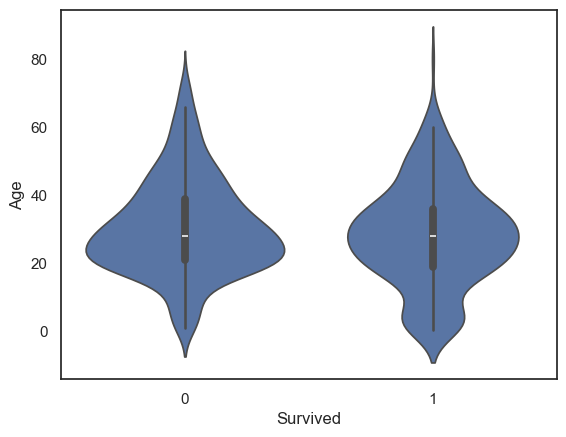

In [526]:
# violinplot of Age grouped by Survived
sns.violinplot(data=train,x="Survived", y="Age")

Sure enough, we find that the non-survival and survival groups had similar means and similar distributions. However, there are a few non-linear differences between them. As we hypothesized, young children under ten survived at higher rates. This is a non-linear relationship that we might want to capture in our model. However, we also observe a high mortality rate for young adults in their early twenties, while adults in the survival group actually skewed a bit older. That might be deference shown to the elderly, or it might be a function of lower-class passengers skewing younger, as we can observe with a violinplot of 'Pclass' against 'Age':

<Axes: xlabel='Pclass', ylabel='Age'>

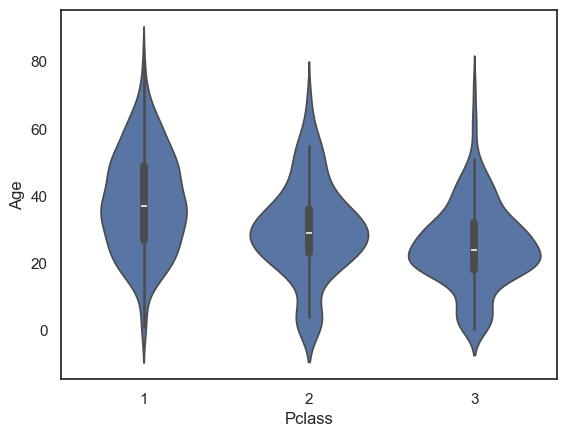

In [527]:
sns.violinplot(x='Pclass',y='Age',data=train)

Since we now know that young children survived preferentially, let's investigate whether their parents were given places in the lifeboats with them. We can do this by filtering the data for passengers over 18 years old and plotting 'Parch' against 'Survived':

<Axes: xlabel='Survived', ylabel='Parch'>

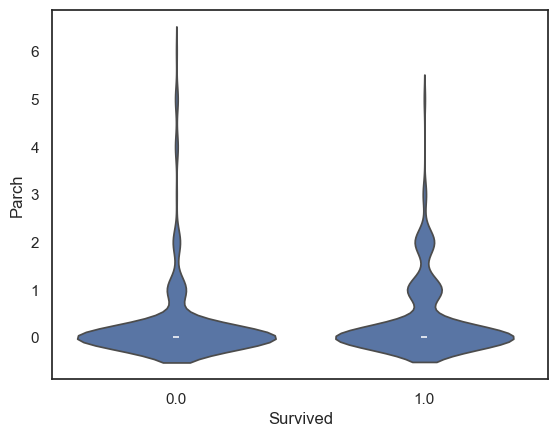

In [528]:
sns.violinplot(x='Survived',y='Parch',data=train.where(cond=train['Age'] > 18))

Interestingly, a few parents with very large families did not survive (perhaps because they had low SES?). However, we can clearly see better survival for parents with 1–3 children, which is consistent with our hypothesis that some parents may have received preferential treatment along with their children.

## Modeling

Now that we've learned some things about our data, we can begin to build a model to predict survival. We begin by installing the additional libraries we will need for our analysis, including scikit-learn, matplotlib, xgboost, seaborn, and numpy. To install these libraries, use `pip install scikit-learn matplotlib xgboost seaborn numpy`.

Next, we need to define a function to preprocess our data for modeling. First, we'll drop the columns we don't plan to use for our analysis: 'Name', 'Cabin', 'Ticket', and 'PassengerId'. Next, since some ML models can't handle missing values, we'll supply missing ages by substituting the median for missing Age and Fare and the mode for missing 'Embarked', while also creating new binary variables to mark which values were missing. Since 'Embarked' is a non-ordinal categorical variable, we'll also need to use one-hot encoding so we can model this variable alongside our ordinal numerical variables. This involves converting the 'Embarked' columns to two binary columns, 'S' and 'Q'. (A value of 'C' will be represented as [0, 0] across the new columns.)

Next, we'll separate dependent from independent variables and use scikit-learn's `train_test_split` function to split the training data into `pretrain` and `validation` sets. We'll use these for model selection and tuning hyperparameters. We'll put 30% of our dataset into the `validation` set. We'll also use scikit-learn's `StandardScaler` to standardize the data (centering the variables around zero and equalizing their variance), which will help our models converge faster. For consistency when using our models to predict the test data, we'll also standardize the test data using the same scaler.

In [529]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import random

# Set seed for reproducibility
seed = 42
np.random.seed(seed=seed)
random.seed(seed)

# Define columns
numerical_columns = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch']
categorical_columns = ['Sex', 'Embarked']
drop_columns = ['Name', 'Cabin', 'Ticket', 'PassengerId']

# Split the data
pretrain, validation = train_test_split(train, test_size=0.3, random_state=seed)

# Separate features and target
x_pretrain = pretrain.drop(labels=['Survived'], axis=1)
y_pretrain = pretrain['Survived']
x_validation = validation.drop(labels=['Survived'], axis=1)
y_validation = validation['Survived']

# Define transformers
transformers = [
    ('drop', 'drop', drop_columns),
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median', add_indicator=True)),
        ('scale', StandardScaler())
    ]), numerical_columns),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
        ('encode', OneHotEncoder(drop='first'))
    ]), categorical_columns)
]

# Create the column transformer
preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

# Debug: Transform the pretrain set using the preprocessor
x_pretrain_transformed = preprocessor.fit_transform(x_pretrain)

# Convert to DataFrame to inspect the transformed data
columns = preprocessor.get_feature_names_out()
print(columns)

['num__Age' 'num__Fare' 'num__Pclass' 'num__SibSp' 'num__Parch'
 'num__missingindicator_Age' 'cat__Sex_1' 'cat__Embarked_Q'
 'cat__Embarked_S' 'cat__missingindicator_Embarked_True']


We'll try several models and compare their performance using the `accuracy_score` metric provided by scikit-learn. Accuracy is defined as the percentage of predictions we get correct. In some contexts it might be more appropriate to use other metrics, such as precision, recall, or F1 score, but for this problem, accuracy is a reasonable metric.

### Linear and Logistic Regression Models

Let's start with simple linear and logistic regression models. We'll use scikit-learn's `LogisticRegression` class for logistic regression and `LinearRegression` class for linear regression. We'll use the `fit` method to fit the model to the training data, and the `predict` method to predict the validation data. We'll then use the `accuracy_score` function to compute the accuracy of our predictions.

In [530]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer

# Define a custom scoring function with 0.5 prediction threshold
def thresholded_accuracy(y_true, y_pred) -> float:
    # Apply thresholding
    y_pred = [1 if x >= 0.5 else 0 for x in y_pred]
    # Calculate and return accuracy
    return accuracy_score(y_true=y_true, y_pred=y_pred)

# Create a custom scorer
custom_scorer = make_scorer(
        score_func=thresholded_accuracy,
        greater_is_better=True,
        needs_threshold=True
    )

# Create and fit a pipeline for linear regression
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
linear_pipeline.fit(x_pretrain, y_pretrain)
linear_predictions = linear_pipeline.predict(x_validation)
linear_accuracy = thresholded_accuracy(y_true=y_validation, y_pred=linear_predictions)

# Create and fit a pipeline for logistic regression
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])
logistic_pipeline.fit(x_pretrain, y_pretrain)
logistic_predictions = logistic_pipeline.predict(x_validation)
logistic_accuracy = accuracy_score(y_true=y_validation, y_pred=logistic_predictions)

# Print the results
print('Linear regression accuracy:', linear_accuracy)
print('Logistic regression accuracy:', logistic_accuracy)

Linear regression accuracy: 0.7947761194029851
Logistic regression accuracy: 0.8208955223880597


The resulting linear and logistic models exhibit accuracy around 79% and 82%, respectively. Not bad! Let's inspect the model intercepts and coefficients:

In [531]:
# Get the coefficients and intercept of the linear model
lin_model = linear_pipeline.named_steps['model']
lin_coefficients = lin_model.coef_
lin_intercept = lin_model.intercept_

# Print the intercept
print("Linear intercept:", lin_intercept)

# Print the coefficients alongside their corresponding features
for feature, coef in zip(columns, lin_coefficients):
    print(f"Linear coefficient for {feature}: {coef}")

# Get the coefficients and intercept of the logistic model
log_model = logistic_pipeline.named_steps['model']
log_coefficients = log_model.coef_
log_intercept = log_model.intercept_

# Print the intercept
print("Logistic intercept:", log_intercept)

# Print the coefficients alongside their corresponding features
for feature, coef in zip(columns, log_coefficients[0]):
    print(f"Logistic coefficient for {feature}: {coef}")

Linear intercept: 0.7729465304382399
Linear coefficient for num__Age: -0.0644869678307038
Linear coefficient for num__Fare: 0.020022828015878846
Linear coefficient for num__Pclass: -0.11880208769865684
Linear coefficient for num__SibSp: -0.03989732849308951
Linear coefficient for num__Parch: -0.01658506965677308
Linear coefficient for num__missingindicator_Age: -0.03046758335727346
Linear coefficient for cat__Sex_1: -0.49292663877634246
Linear coefficient for cat__Embarked_Q: -0.004844486062290181
Linear coefficient for cat__Embarked_S: -0.10546027601692806
Linear coefficient for cat__missingindicator_Embarked_True: 0.12148658445603125
Logistic intercept: [1.36132297]
Logistic coefficient for num__Age: -0.4206586577770631
Logistic coefficient for num__Fare: 0.1263966002959271
Logistic coefficient for num__Pclass: -0.7330351020697731
Logistic coefficient for num__SibSp: -0.3210805614230411
Logistic coefficient for num__Parch: -0.0860700104556861
Logistic coefficient for num__missingindi

Inspecting the models reveals that the predictions are premised mostly on Sex and Pclass. Embarked_S and Age are weaker predictors (each effect somewhat modified by our dummy variables that indicate whether the values have been imputed). SibSp is a more distant runner-up.

As we learned during data exploration, Age has a nonlinear relationship to Survived. 82% accuracy is solid, but we can probably do better with a model that accounts for some of the nonlinearity. Let's try some more sophisticated models.

### Decision Tree Models

On many data science problems, Extra Trees and Random Forest models are among the top performers. These are basically ensemble models that combine many decision trees. Let's start with a naive decision tree model, and then try some ensemble models.

A decision tree regressor is a tree-like model where decisions are made based on asking a series of questions. It is a supervised learning algorithm that can be used for both classification and regression tasks. The algorithm tries to split the data into subsets based on the feature values. This is done recursively in a greedy manner by choosing the split that results in the largest reduction in variance (for regression) or in impurity (for classification, using metrics like Gini impurity or entropy). The algorithm stops when it reaches a predefined stopping criterion, such as when the tree reaches a certain depth, or when the number of samples in a node falls below a certain threshold. These "hyperparameters" can be tuned to improve the model's performance.

In the following code, we will use scikit-learn's `DecisionTreeClassifier` class to fit a decision tree model to the training data and `GridSearchCV` to tune the hyperparameters. We'll use the `predict` method to predict the validation data, and the `accuracy_score` function to compute the accuracy of our predictions.

In [532]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define preprocessing pipeline
preprocessing = Pipeline([
    ('preprocessor', preprocessor)
])

# Define the full pipeline with preprocessing and model
dt_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', DecisionTreeClassifier(random_state=seed))
])

# Define the hyperparameters and their possible values
param_distributions = {
    'model__max_depth': [None] + list(range(1, 8)),
    'model__min_samples_split': range(2, 11),
    'model__min_samples_leaf': range(1, 5),
    'model__max_features': [None, 'sqrt', 'log2']
}

# Use RandomizedSearchCV to search for the best hyperparameters
random_search = RandomizedSearchCV(
        estimator=dt_pipeline, 
        param_distributions=param_distributions, 
        scoring=custom_scorer, 
        cv=5,
        n_iter=100,
        random_state=seed,
        n_jobs=-1
    )

# Fit the model
random_search.fit(x_pretrain, y_pretrain)

# Get the best hyperparameters from the grid search
best_params = random_search.best_params_

# Get the best estimator and make predictions
best_dt = random_search.best_estimator_
dt_prediction = best_dt.predict(X=x_pretrain)
dt_score = thresholded_accuracy(y_true=y_pretrain, y_pred=dt_prediction)

# Print the hyperparameters and thresholded accuracy score
print("Best hyperparameters:\n", best_params)
print("DT accuracy with best hyperparameters:", dt_score)

Best hyperparameters:
 {'model__min_samples_split': 6, 'model__min_samples_leaf': 3, 'model__max_features': None, 'model__max_depth': 3}
DT accuracy with best hyperparameters: 0.8314606741573034


Accuracy for this model is around 83%, a little better than logistic regression. One of the advantages of a decision tree model is its interpretability. Let's visualize the decision tree:

In [533]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(decision_tree=best_dt, feature_names=columns, filled=True, rounded=True, fontsize=10)
plt.show()

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['Name',
                                                                    'Cabin',
                                                                    'Ticket',
                                                                    'PassengerId']),
                                                                  ('num',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(add_indicator=True,
                                                                                                  strategy='median')),
                                                                                   ('scale',
                                                                                    StandardScaler())]),
                                                                   ['Age',
                                                                    'Fare',
                                                                    'Pclass',
                                                                    'SibSp',
                                                                    'Parch']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(add_indicator=True,
                                                                                                  strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(drop='first'))]),
                                                                   ['Sex',
                                                                    'Embarked'])]))])),
                ('model',
                 DecisionTreeClassifier(max_depth=3, min_samples_leaf=3,
                                        min_samples_split=6,
                                        random_state=42))]) instead.

<Figure size 2000x1000 with 0 Axes>

Sex, Pclass, and Age are again the most important variables, with Fare and SibSp playing smaller roles in the model.

Let's try some ensemble models to see if we can do even better. A random forest is an ensemble method that creates a 'forest' of decision trees. Each tree is trained on a subset of the data and gives a prediction. The random forest aggregates these predictions to produce a final result. Random forests use bootstrap aggregating (or bagging) to sub-sample the data used to train each tree, introducing randomness. Features for splitting nodes are also selected from a random subset of the available features. As with decision trees, the stopping criteria can be tuned to improve the model's performance.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Define the RandomForest pipeline with preprocessing
rfc_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestClassifier(random_state=seed))
])

# Define the hyperparameters and their possible values
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__max_features': ['auto', 'sqrt', 'log2', None],
    'model__max_depth': [None] + list(range(1, 40)),
    'model__min_samples_split': randint(1, 20),
    'model__min_samples_leaf': randint(1, 20),
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy']
}

# Use RandomizedSearchCV to search for the best hyperparameters
random_search = RandomizedSearchCV(
        estimator=rfc_pipeline,
        param_distributions=param_distributions,
        scoring=custom_scorer,
        cv=5,
        n_iter=100,
        random_state=seed,
        n_jobs=-1
    )

# Fit the model
random_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = random_search.best_params_

# Get the best estimator and make predictions
best_rfc = random_search.best_estimator_
rfc_prediction = best_rfc.predict(X=x_validation)
rfc_score = thresholded_accuracy(y_true=y_validation, y_pred=rfc_prediction)

# Print the hyperparameters and thresholded accuracy score
print("Best hyperparameters:\n", best_params)
print("RFC accuracy with best hyperparameters:", rfc_score)

Best hyperparameters:
 {'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 311}
RFC accuracy with best hyperparameters: 0.8022388059701493


Surprisingly, our random forest model underperforms a simple decision tree, with accuracy around 80%. This may be because it's overfitting. Let's inspect the model to see the feature importances:

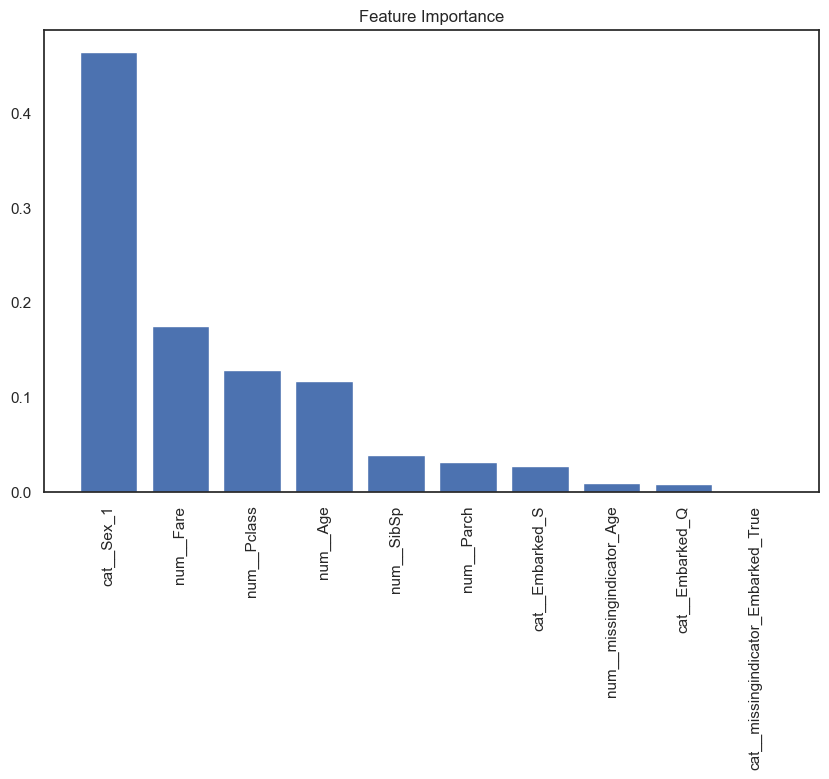

In [ ]:
# Get feature importances
importances = best_rfc.named_steps['model'].feature_importances_

# Get feature names directly from the preprocessor after transformations
features = best_rfc.named_steps['preprocessing'].get_feature_names_out()

# Ensure that the number of features matches
assert len(features) == len(importances), "Mismatch between number of features and importances"

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(names)), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(names)), names, rotation=90)

# Display the plot
plt.show()

Sex remains the most important variable. But interestingly, in this model, Fare leapfrogs Age and Pclass to move into second place!

Let's see if an Extra Trees model can help us mitigate overfitting. The Extra Trees Regressor model, also known as Extremely Randomized Trees, is similar to a Random Forest model, but it uses a random threshold for each feature rather than finding the best possible threshold. This results in a higher variance for the predictions, but a lower bias, which can improve the model's performance.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Define the pipeline incorporating the preprocessor and the classifier
etc_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', ExtraTreesClassifier(random_state=seed))
])

# Adjust the parameter distributions to account for the pipeline
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__max_features': [None, 'log2', 'sqrt', 'auto'],
    'model__criterion': ['entropy', 'gini'],
    'model__max_depth': [None] + list(range(1, 40)),
    'model__min_samples_split': randint(1, 20),
    'model__min_samples_leaf': randint(1, 20)
}

# Run the randomized search
random_search = RandomizedSearchCV(
    estimator=etc_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=custom_scorer,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

# Fit the model to the unprocessed data directly
random_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the search
best_params = random_search.best_params_

# Set the clf to the best combination of parameters
best_etc = random_search.best_estimator_

# Make predictions
etc_prediction = best_etc.predict(X=x_validation)
etc_score = thresholded_accuracy(y_true=y_validation, y_pred=etc_prediction)

# Print the hyperparameters and thresholded accuracy score
print("Best hyperparameters:\n", best_params)
print("ETC accuracy with best hyperparameters:", etc_score)


Best hyperparameters:
 {'model__criterion': 'entropy', 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 7, 'model__min_samples_split': 9, 'model__n_estimators': 348}
ETC accuracy with best hyperparameters: 0.8097014925373134


The Extra Trees model only slightly outperforms Random Forest, with accuracy around 81%. Let's inspect this model.

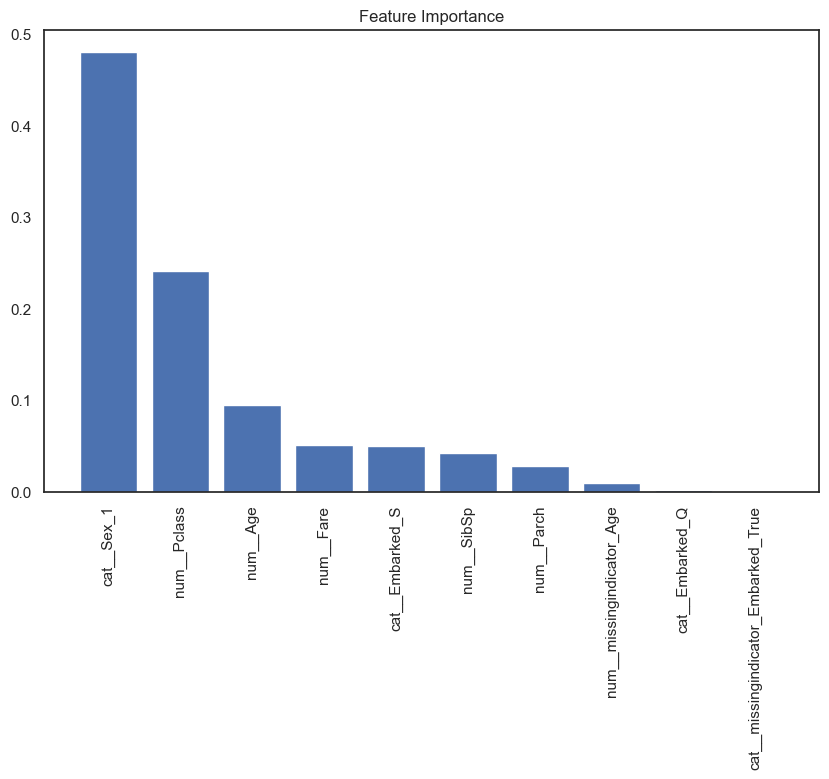

In [ ]:
# Get feature importances
importances = best_etc.named_steps['model'].feature_importances_

# Get feature names directly from the preprocessor after transformations
features = best_etc.named_steps['preprocessing'].get_feature_names_out()

# Ensure that the number of features matches
assert len(features) == len(importances), "Mismatch between number of features and importances"

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features[i] for i in indices]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(len(names)), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(len(names)), names, rotation=90)

# Display the plot
plt.show()

The importances in this model are more in line with the regression models we trained earlier, which is reassuring. 

We've achieved a solid performance on the Titanic dataset, but let's see if we can do better with a gradient boosting model.

### Gradient Boosting Models

[XGBoost](https://en.wikipedia.org/wiki/XGBoost) is an open-source gradient boosting framework. It is a supervised learning algorithm that can be used for both classification and regression tasks. It is an ensemble model that combines many weak learners (in this case, decision trees) to produce a strong learner. It uses gradient boosting to minimize a loss function when adding new models to the ensemble. The loss function is typically a measure of error, such as mean squared error for regression or cross-entropy for classification. The algorithm starts with an initial model, then iteratively adds new models to the ensemble, each time minimizing the loss function. The new models are added in a greedy manner, so that the loss function is minimized at each step. The algorithm stops when it reaches a predefined stopping criterion, such as when the number of models reaches a certain threshold, or when the loss function falls below a certain threshold.

In [ ]:
import xgboost as xgb
from scipy.stats import randint, uniform
import warnings

# Ignore annoying warnings about deprecated functions used by xgboost
warnings.filterwarnings(action='ignore')

# Define the pipeline incorporating the preprocessor and the classifier
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', xgb.XGBClassifier(objective='binary:logistic', random_state=seed, use_label_encoder=False, eval_metric='logloss'))
])

# Define parameter distributions
param_distributions = {
    'model__n_estimators': randint(5, 500),
    'model__learning_rate': uniform(0.01, 0.1),
    'model__max_depth': randint(1, 40),
    'model__subsample': uniform(0.1, 0.5),
    'model__colsample_bytree': uniform(0.1, 0.2)
}

# Run the randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring=custom_scorer,
    cv=5,
    random_state=seed,
    n_jobs=-1
)

# Fit the model
random_search.fit(X=x_pretrain, y=y_pretrain)

# Get the best hyperparameters from the grid search
best_params = random_search.best_params_

# Fit the best algorithm to the data
best_xgb = random_search.best_estimator_
xgb_prediction = best_xgb.predict(X=x_validation)
xgb_score = thresholded_accuracy(y_true=y_validation, y_pred=xgb_prediction)

# Print the hyperparameters and thresholded accuracy score
print("Best hyperparameters:\n", best_params)
print("XGB accuracy with best hyperparameters:", xgb_score)

Best hyperparameters:
 {'model__colsample_bytree': 0.2792182599846986, 'model__learning_rate': 0.04180034749718639, 'model__max_depth': 33, 'model__n_estimators': 389, 'model__subsample': 0.21396758127097085}
XGB accuracy with best hyperparameters: 0.8208955223880597


This model outperforms both Random Forest and Extra Trees, with accuracy around 82%. (It also trains much faster than either of those models; XGBoost is wonderfully optimized.) The top variables in this model are Sex and Pclass, followed by Fare and Age. Let's inspect the model:

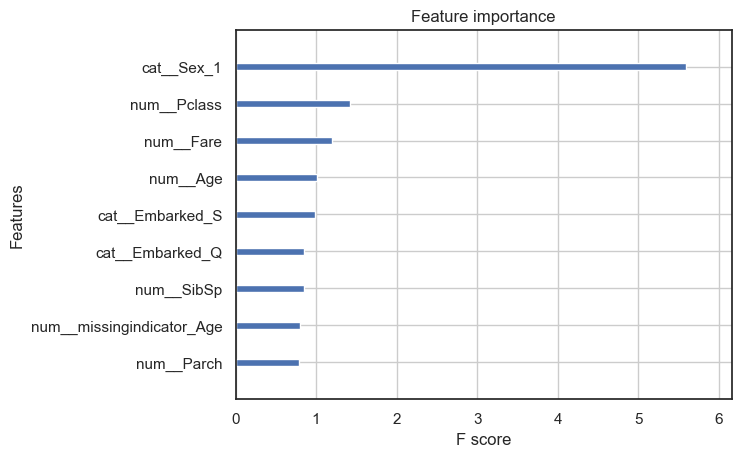

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Map 'f0', 'f1', ... to the actual feature names
mapper = {f'f{i}': feature for i, feature in enumerate(columns)}

# Plot feature importance with actual feature names
ax = plot_importance(booster=best_xgb.named_steps['model'], importance_type='gain', show_values=False)
ax.set_yticklabels([mapper.get(ylabel.get_text()) for ylabel in ax.get_yticklabels()])
plt.show()

Without some additional feature engineering, 82% is probably the best we can do. Let's re-train the best-performing model on the full training dataset and use it to predict the test data and submit our results to Kaggle.

## Final Training Phase

We'll use the best-performing model, XGBoost, to predict the test data. We'll then use the `accuracy_score` function to compute the accuracy of our final predictions.

In [534]:
# Use best model to make predictions on the test set
xgb_prediction = best_xgb.predict(X=test)

# Convert the predictions to a Pandas DataFrame with PassengerId and Survived columns
submission = pd.DataFrame(data={
        "PassengerId": test["PassengerId"],
        "Survived": xgb_prediction
    })

# Write the submission DataFrame to a CSV file
submission.to_csv(path_or_buf='data/submission.csv', index=False)